In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [11]:
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [12]:
print(f"Available datasets: {dataset_names}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [13]:
dataset = get_dataset("m4_hourly")

In [45]:
len(dataset.train)

414

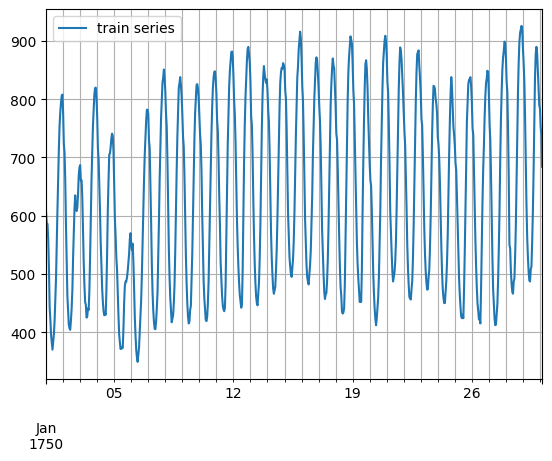

In [14]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

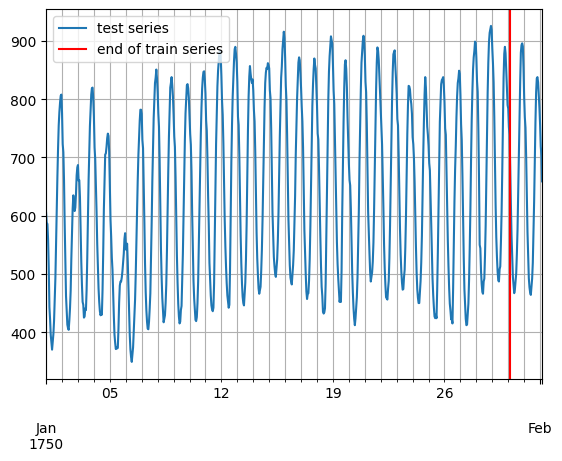

In [15]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [9]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [16]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Period("01-01-2019", freq=freq) 

In [17]:
from gluonts.dataset.common import ListDataset

In [18]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset[:, :-prediction_length]],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": start} for x in custom_dataset], freq=freq
)

In [19]:
from gluonts.mx import SimpleFeedForwardEstimator, Trainer

In [20]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [21]:
predictor = estimator.train(dataset.train)

100%|██████████| 100/100 [00:00<00:00, 140.26it/s, epoch=5/5, avg_epoch_loss=4.67]


In [22]:
from gluonts.evaluation import make_evaluation_predictions

In [23]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [24]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [25]:
# first entry of the time series list
ts_entry = tss[0]

In [26]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([605., 586., 586., 559., 511.], dtype=float32)

In [27]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))

In [28]:
# first 5 values
dataset_test_entry["target"][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [29]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [30]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00
Frequency of the time series: <Hour>


In [31]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [615.1951  565.0542  565.2271  494.27722 542.6453  481.47958 514.7239
 471.30283 536.24927 546.64844 608.7035  659.6585  699.9186  823.69653
 845.52094 826.07056 845.6679  874.37646 813.3274  848.7018  792.3635
 904.6733  771.5327  850.99554 607.35095 654.72736 490.8191  506.14847
 578.9832  455.02417 515.8466  461.9125  491.46817 574.97424 692.4478
 671.3622  733.7957  814.51556 847.79266 928.4535  853.06256 897.96814
 953.1433  821.78375 924.9242  692.55    725.25275 740.0838 ]
0.5-quantile (median) of the future window:
 [615.361   568.79156 557.079   496.12836 533.41064 488.2479  508.9484
 490.87198 537.6241  549.83014 582.16785 652.8644  713.61346 822.5964
 845.4137  829.0973  882.45374 887.0237  805.8511  857.2663  782.8251
 904.3364  767.71326 832.2235  610.77094 655.54205 495.89096 497.61252
 588.5538  454.20605 525.36127 465.26013 506.07904 572.66113 692.6386
 674.00586 735.82825 806.80426 838.32324 926.708   866.3421  904.7343
 893.67816 827.4142  

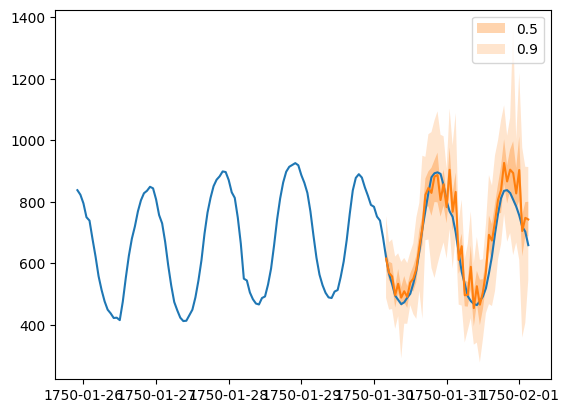

In [32]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [33]:
from gluonts.evaluation import Evaluator

In [34]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 414it [00:00, 2274.17it/s]


In [35]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 12936544.773519926,
    "abs_error": 10772394.257953644,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.172541767115191,
    "MAPE": 0.25100288631307527,
    "sMAPE": 0.18675287654578399,
    "MSIS": 62.08098313287314,
    "QuantileLoss[0.1]": 4945802.006304455,
    "Coverage[0.1]": 0.12786835748792275,
    "QuantileLoss[0.5]": 10772394.173166275,
    "Coverage[0.5]": 0.5302938808373591,
    "QuantileLoss[0.9]": 7097593.8877980225,
    "Coverage[0.9]": 0.8843599033816425,
    "RMSE": 3596.740854373571,
    "NRMSE": 0.49103457179163773,
    "ND": 0.0740071335510382,
    "wQuantileLoss[0.1]": 0.03397802019057346,
    "wQuantileLoss[0.5]": 0.07400713296854279,
    "wQuantileLoss[0.9]": 0.048760987220410466,
    "mean_absolute_QuantileLoss": 7605263.35575625,
    "mean_wQuantileLoss": 0.05224871345984224,
    "MAE_Coverage": 0.3947866344605475,
    "OWA": NaN
}


In [36]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0,1750-01-30 04:00,3920.220703,2064.054932,31644.0,659.250000,42.371302,1.014865,0.066115,0.062857,0.065227,12.642766,927.105487,0.020833,2064.054840,0.770833,1430.457239,1.000000
1,1,1750-01-30 04:00,203116.895833,19747.585938,124149.0,2586.437500,165.107988,2.491751,0.167176,0.151084,0.159064,14.542501,5190.048267,0.312500,19747.587158,0.979167,8804.037451,1.000000
2,2,1750-01-30 04:00,34177.328125,6529.280273,65030.0,1354.791667,78.889053,1.724278,0.090872,0.096989,0.100404,12.326088,3453.327295,0.000000,6529.280457,0.187500,2839.189905,0.770833
3,3,1750-01-30 04:00,255600.312500,19270.863281,235783.0,4912.145833,258.982249,1.550208,0.080063,0.079181,0.081731,14.155496,9473.508496,0.020833,19270.862305,0.437500,7810.351562,0.979167
4,4,1750-01-30 04:00,108484.895833,11804.849609,131088.0,2731.000000,200.494083,1.226642,0.086680,0.082303,0.090053,12.564213,4201.249951,0.083333,11804.850586,0.666667,7080.844385,1.000000


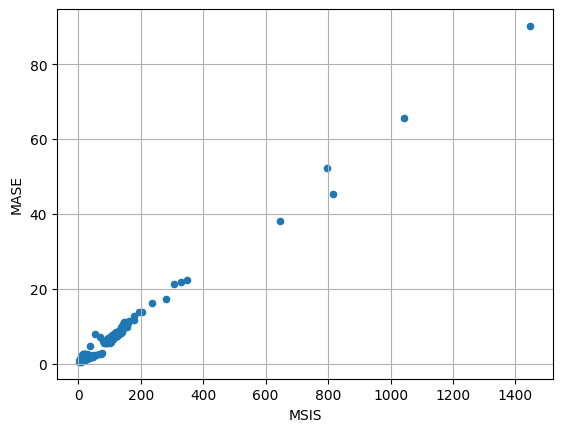

In [37]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

##### Feature incorporation

In [46]:
from gluonts.dataset.field_names import FieldName

In [47]:
def create_dataset(num_series, num_steps, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # pattern - sinusoid with different phase
    sin_minusPi_Pi = np.sin(
        np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period))
    )
    sin_Zero_2Pi = np.sin(
        np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period))
    )

    pattern = np.concatenate(
        (
            np.tile(sin_minusPi_Pi.reshape(1, -1), (int(np.ceil(num_series / 2)), 1)),
            np.tile(sin_Zero_2Pi.reshape(1, -1), (int(np.floor(num_series / 2)), 1)),
        ),
        axis=0,
    )

    target = noise + pattern

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate(
        (np.zeros((num_series, period)), target[:, :-period]), axis=1
    )

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate(
        (
            np.zeros(int(np.ceil(num_series / 2))),
            np.ones(int(np.floor(num_series / 2))),
        ),
        axis=0,
    )

    return target, feat_dynamic_real, feat_static_cat

In [48]:
# define the parameters of the dataset
custom_ds_metadata = {
    "num_series": 100,
    "num_steps": 24 * 7,
    "prediction_length": 24,
    "freq": "1H",
    "start": [pd.Period("01-01-2019", freq="1H") for _ in range(100)],
}

In [49]:
data_out = create_dataset(
    custom_ds_metadata["num_series"],
    custom_ds_metadata["num_steps"],
    custom_ds_metadata["prediction_length"],
)

target, feat_dynamic_real, feat_static_cat = data_out

In [74]:
type(target)

numpy.ndarray

In [61]:
len(target)

100

In [75]:
len(target[:, : -custom_ds_metadata["prediction_length"]])

100

In [65]:
len(custom_ds_metadata["start"])

100

In [66]:
len(feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]])

100

In [77]:
target.ndim

2

In [69]:
custom_ds_metadata["freq"]

'1H'

In [70]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target[:, : -custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]],
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [80]:
type(feat_dynamic_real[0])

numpy.ndarray

In [68]:
len(feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]])

100

In [51]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target, custom_ds_metadata["start"], feat_dynamic_real, feat_static_cat
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [60]:
train_ds[1]

{'target': array([ 1.4192944 ,  0.22588083,  0.41968718,  0.43170902,  0.5125134 ,
         0.7046352 ,  0.07233655, -0.02975793,  0.3155652 , -0.01018748,
         0.4989137 ,  1.2253138 ,  1.5112562 ,  1.426887  ,  1.6698523 ,
         1.9241275 ,  1.7145052 ,  2.0389977 ,  2.146541  ,  1.5227097 ,
         1.7332344 ,  1.4781556 ,  1.333598  ,  0.2146491 ,  0.5636409 ,
         0.5913187 ,  0.53065675,  0.4369921 ,  0.385005  ,  0.33528185,
         0.16263166, -0.06481556,  0.5029369 ,  0.26161668,  0.8639937 ,
         0.83943605,  0.9787632 ,  1.3726506 ,  1.4824598 ,  1.9472831 ,
         1.7754741 ,  2.063664  ,  1.5152173 ,  1.8614992 ,  1.719146  ,
         1.5501423 ,  1.2215052 ,  1.0240612 ,  1.5471661 ,  1.0865933 ,
         0.4027525 ,  0.21635413,  0.43460914,  0.3293619 ,  0.38472068,
         0.00899105,  0.29625157,  0.06714166,  0.56640416,  0.7381934 ,
         1.382139  ,  1.3056082 ,  1.7932808 ,  1.9089521 ,  2.4308743 ,
         1.7986472 ,  1.4648929 ,  1.7003